In [2]:
import pandas as pd
import numpy as np

### 1. Загрузить данные: 'insurance.csv'. Вывести и провести предобработку. Вывести список уникальных регионов.

In [3]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### 2. Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI),
### используя первый способ, через библиотеку Scipy.

In [7]:
import scipy.stats as sts
res = sts.f_oneway(
    data.loc[data.region == 'southwest'].bmi,
    data.loc[data.region == 'southeast'].bmi,
    data.loc[data.region == 'northwest'].bmi,
    data.loc[data.region == 'northwest'].bmi)
res

F_onewayResult(statistic=41.90430395734942, pvalue=7.037796997047164e-26)

### 3. Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI),
### используя второй способ, с помощью функции anova_lm() из библиотеки statsmodels.

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('bmi ~ region', data=data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

                sum_sq      df          F        PR(>F)
region     4055.880631     3.0  39.495057  1.881839e-24
Residual  45664.319755  1334.0        NaN           NaN


### 4. С помощью t критерия Стьюдента перебрать все пары. Определить поправку Бонферрони. Сделать выводы.

In [9]:
from itertools import combinations
pairs = combinations(data.region.unique(), 2)
pairs = list(pairs)
print("поправка Бонферрони:", 0.05 / len(pairs))
for reg1, reg2 in pairs:
    print(reg1, reg2)
    res = sts.ttest_ind(data.loc[data.region == reg1].bmi, data.loc[data.region == reg2].bmi)
    print(res, f'- {True if res.pvalue > 0.05 / len(pairs) else False}')

поправка Бонферрони: 0.008333333333333333
southwest southeast
Ttest_indResult(statistic=-5.908373821545118, pvalue=5.4374009639680636e-09) - False
southwest northwest
Ttest_indResult(statistic=3.2844171500398582, pvalue=0.001076958496307695) - False
southwest northeast
Ttest_indResult(statistic=3.1169000930045923, pvalue=0.0019086161671573074) - False
southeast northwest
Ttest_indResult(statistic=9.25649013552548, pvalue=2.643571405230106e-19) - False
southeast northeast
Ttest_indResult(statistic=8.790905562598699, pvalue=1.186014937424813e-17) - False
northwest northeast
Ttest_indResult(statistic=0.060307727183293185, pvalue=0.951929170821864) - True


### 5. Выполнить пост-хок тесты Тьюки и построить график.

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,0.0263,0.9999,-1.1552,1.2078,False
northeast,southeast,4.1825,0.0,3.033,5.332,True
northeast,southwest,1.4231,0.0107,0.2416,2.6046,True
northwest,southeast,4.1562,0.0,3.0077,5.3047,True
northwest,southwest,1.3968,0.0127,0.2162,2.5774,True
southeast,southwest,-2.7594,0.0,-3.9079,-1.6108,True


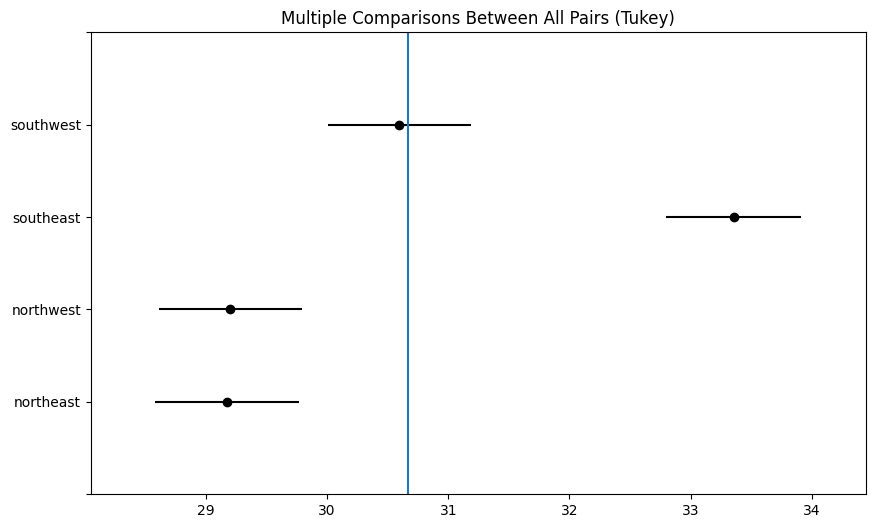

In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib import pyplot as plt
tukey = pairwise_tukeyhsd(endog=data.bmi, groups=data.region, alpha=0.05)
tukey.plot_simultaneous()
plt.axvline(x=data.bmi.mean())
tukey.summary()

### 6. Выполнить двухфакторный ANOVA тест, чтобы проверить влияние региона и пола на индекс массы тела (BMI),
### используя функцию anova_lm() из библиотеки statsmodels.

In [11]:
model = ols('bmi ~ region + sex', data=data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)

                sum_sq      df          F        PR(>F)
region     4034.975135     3.0  39.336119  2.342323e-24
sex          86.007035     1.0   2.515393  1.129767e-01
Residual  45578.312720  1333.0        NaN           NaN


### 7. Выполнить пост-хок тесты Тьюки и построить график.

group1,group2,meandiff,p-adj,lower,upper,reject
northeast/female,northeast/male,-0.2998,0.9998,-2.2706,1.6711,False
northeast/female,northwest/female,-0.0464,1.0,-2.0142,1.9215,False
northeast/female,northwest/male,-0.2042,1.0,-2.1811,1.7728,False
northeast/female,southeast/female,3.3469,0.0,1.41,5.2839,True
northeast/female,southeast/male,4.6657,0.0,2.7634,6.568,True
northeast/female,southwest/female,0.7362,0.9497,-1.2377,2.71,False
northeast/female,southwest/male,1.8051,0.1007,-0.1657,3.776,False
northeast/male,northwest/female,0.2534,0.9999,-1.7083,2.2152,False
northeast/male,northwest/male,0.0956,1.0,-1.8752,2.0665,False
northeast/male,southeast/female,3.6467,0.0,1.7159,5.5775,True


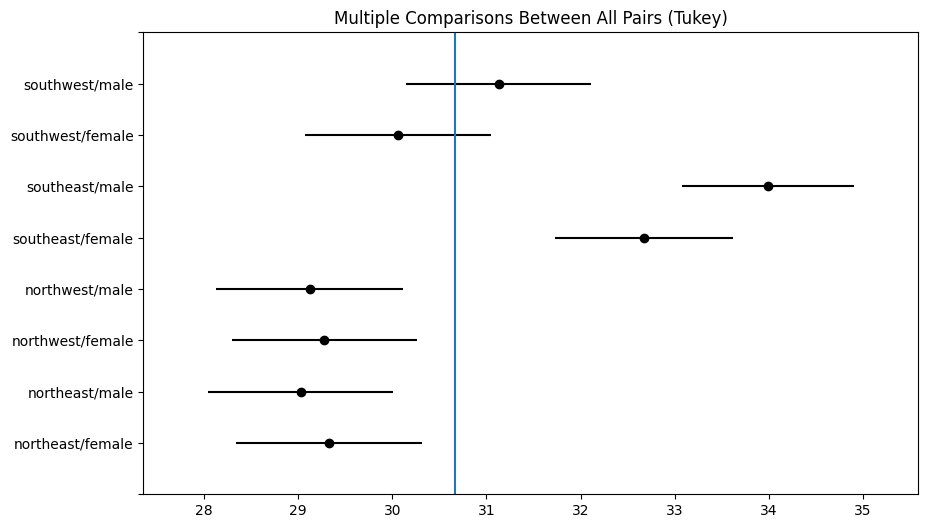

In [12]:
data['comb'] = data.region + '/' + data.sex
tukey = pairwise_tukeyhsd(endog=data.bmi, groups=data.comb, alpha=0.05)
tukey.plot_simultaneous()
plt.axvline(x=data.bmi.mean())
tukey.summary()